Code written by: Billy Atkinson (watkinson@umces.edu) \
Paper Citation: Mason, E., A. Pascual, and J. C. McWilliams, 2014: A new sea surface height–based code for oceanic mesoscale eddy tracking. J. Atmos. Oceanic Technol., 31, 1181–1188, doi:10.1175/JTECH-D-14-00019.1. \
Source Code: __[Pixels inside/outside Eddies Documentation](https://py-eddy-tracker.readthedocs.io/en/latest/python_module/06_grid_manipulation/pet_hide_pixel_out_eddies.html#sphx-glr-python-module-06-grid-manipulation-pet-hide-pixel-out-eddies-py)__ \
Date of last revision: 01/10/2023 \
This code visually inspect each mas calculation to make sure it is working effectively

In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4 as nc
import datetime as dt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from scipy.stats import linregress
import numpy.ma as ma
import glob
import os
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.observations.observation import EddiesObservations

In [2]:
from matplotlib import pyplot as plt
from numpy import cos, linspace, radians, sin

from py_eddy_tracker import data
from py_eddy_tracker.generic import coordinates_to_local, local_to_coordinates
from py_eddy_tracker.observations.observation import EddiesObservations
from py_eddy_tracker.poly import fit_circle_, fit_ellipse

def build_circle(x0, y0, r):
    angle = radians(linspace(0, 360, 50))
    x_norm, y_norm = cos(angle), sin(angle)
    return local_to_coordinates(x_norm * r, y_norm * r, x0, y0)


def build_ellipse(x0, y0, a, b, theta):
    angle = radians(linspace(0, 360, 50))
    x = a * cos(theta) * cos(angle) - b * sin(theta) * sin(angle)
    y = a * sin(theta) * cos(angle) + b * cos(theta) * sin(angle)
    return local_to_coordinates(x, y, x0, y0)

We assume pixel position of grid is centered for /data/watkinson/Fall2022/Sat_data/1day_regrid/CAFE_GOM_day_20030103.nc


0.35093418


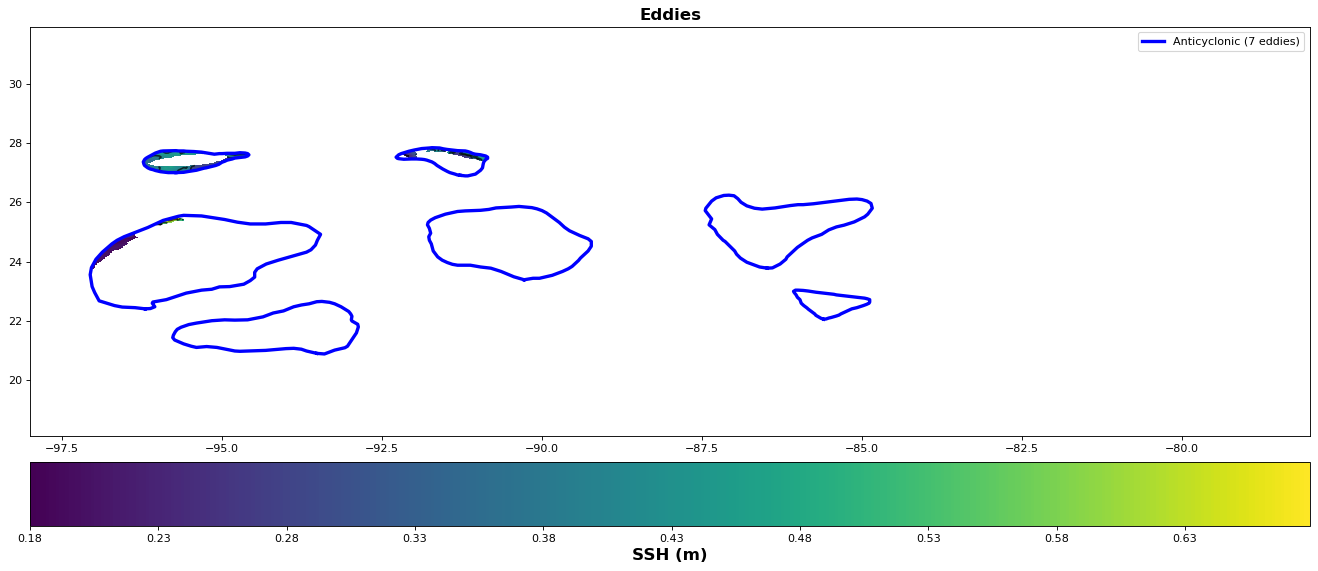

In [75]:
sat_files = sorted(glob.glob('/data/watkinson/Fall2022/Sat_data/1day_regrid/*.nc'))
#sat_files = sat_files[0:8]
anti_files = sorted(glob.glob('/data/watkinson/Fall2022/Eddy_data/GoM_tuned_eddies/Anticyclonic/Anticyclonic_*.nc'))

cycl_files = sorted(glob.glob('/data/watkinson/Fall2022/Eddy_data/GoM_tuned_eddies/Cyclonic/Cyclonic_*.nc'))

SSH_files = sorted(glob.glob('/data/watkinson/Fall2022/SSH_data/Cropped_SSH_Data/*.nc'))
#sat_data = RegularGridDataset((SSH_files[2]),
    #"lon",
    #"lat")
a = EddiesObservations.load_file(anti_files[2])
######Cyclonic data

c = EddiesObservations.load_file(cycl_files[2])
#print(c)


 ###### Sat data
sat_data = RegularGridDataset((sat_files[2]),
    "lon",
    "lat")

from matplotlib.path import Path
from numpy import ones
from py_eddy_tracker.poly import create_vertice
x_name_anti, y_name_anti = a.intern(False)# We will use the outter effective contour and not the inner speed contour
#print(x_name_anti[0])
adt_anti = sat_data.grid("chlor_a")
#print(adt_anti)
mask_anti = ones(adt_anti.shape, dtype="bool")#creates boolean array to use in masking values for anticyclonic eddies
mask_anti2 = ones(adt_anti.shape, dtype="bool")
######takes the vertice points that defines the eddy edge and finds i,j pixels outside of those vertices

################################ Eddy Edge View

for eddy in a:
    #sat_data = RegularGridDataset((sat_files[n]),"lon","lat")
    #adt_anti = sat_data.grid("chlor_a")
    #mask_anti = ones(adt_anti.shape, dtype="bool")#creates boolean array to use in masking values for anticyclonic eddies
    i, j = Path(create_vertice(eddy[x_name_anti], eddy[y_name_anti])).pixels_in(sat_data)
    mask_anti[i, j] = False
    adt_anti.mask[:] = mask_anti

    #mask_anti2 = ones(adt_anti.shape, dtype="bool")
    xs, ys = eddy[x_name_anti], eddy[y_name_anti]
    x0_, y0_ = xs.mean(), ys.mean()
    x_, y_ = coordinates_to_local(xs, ys, x0_, y0_)
    x0, y0, a, b, theta = fit_ellipse(x_, y_)
    x0, y0 = local_to_coordinates(x0, y0, x0_, y0_)
    w=-2*(10000)+a
    h=-2*(10000)+b
    z,z0= build_ellipse(x0, y0, w, h, theta)
    i2, j2 = Path(create_vertice(z, z0)).pixels_in(sat_data)
    mask_anti2[i2, j2] = False
    adt_anti.mask[:] += ~mask_anti2
    #adt_anti = np.transpose(adt_anti)
    #adt_anti = ma.masked_where(adt_anti==0,adt_anti)
    #mean_anti = np.nanmean(adt_anti)
    #mean_anti = np.mean(adt_anti)
    #mean_anti = np.atleast_1d(np.array(mean_anti))

########################################## Eddy Center View
'''
for eddy in a:
    #sat_data = RegularGridDataset((sat_files[n]),"lon","lat")
    #adt_anti = sat_data.grid("chlor_a")
    #mask_anti2 = ones(adt_anti.shape, dtype="bool")
    xs, ys = eddy[x_name_anti], eddy[y_name_anti]
    x0_, y0_ = xs.mean(), ys.mean()
    x_, y_ = coordinates_to_local(xs, ys, x0_, y0_)
    x0, y0, a, b, theta = fit_ellipse(x_, y_)
    x0, y0 = local_to_coordinates(x0, y0, x0_, y0_)
    w=-2*(8000)+a
    h=-2*(8000)+b
    z,z0= build_ellipse(x0, y0, w, h, theta)
    i2, j2 = Path(create_vertice(z, z0)).pixels_in(sat_data)
    mask_anti2[i2, j2] = False
    adt_anti.mask[:] = mask_anti2
'''
'''
################# Eddy Surrounding View
#lon_center,lat_center =a.longitude, a.latitude
for eddy in a:
    xs, ys = eddy[x_name_anti], eddy[y_name_anti]
    #x0,y0 = long_center
    x0_, y0_ = xs.mean(), ys.mean()
    x_, y_ = coordinates_to_local(xs, ys, x0_, y0_)
    x0, y0, radius, shape_error = fit_circle_(x_, y_)
    print(radius)
    x0, y0 = local_to_coordinates(x0, y0, x0_, y0_)
    z,z0=build_circle(x0, y0, radius*2)
    i2, j2 = Path(create_vertice(z, z0)).pixels_in(sat_data)
    mask_anti2[i2, j2] = False
adt_anti.mask[:] = mask_anti2

for eddy in a:
    #sat_data = RegularGridDataset((sat_files[n]),"lon","lat")
    #adt_anti = sat_data.grid("chlor_a")
    #mask_anti = ones(adt_anti.shape, dtype="bool")#creates boolean array to use in masking values for anticyclonic eddies
    i, j = Path(create_vertice(eddy[x_name_anti], eddy[y_name_anti])).pixels_in(sat_data)
    mask_anti[i, j] = False
    adt_anti.mask[:] += ~mask_anti
    #adt_anti.mask[:] = mask_anti
'''


'''
for eddy in c:
    i, j = Path(create_vertice(eddy[x_name_anti], eddy[y_name_anti])).pixels_in(sat_data)
    mask_anti[i, j] = False
adt_cycl.mask[:] = mask_anti 
'''

adt_anti  = np.transpose(adt_anti)
adt_anti = ma.masked_where(adt_anti==0,adt_anti)
mean_anti = np.nanmean(adt_anti)
#adt_anti2  = np.transpose(adt_anti2)
#adt_anti2 = ma.masked_where(adt_anti2==0,adt_anti2)
#mean_anti2 = np.nanmean(adt_anti2)
print(mean_anti)

fig = plt.figure(figsize=(20, 8), dpi=80)
ax = fig.add_axes([.03,.03,.8,.8])
plt.title('Eddies',loc='center',fontsize=15,fontweight='bold')#,y=1.03)
      
SSH_data = xr.open_dataset(sat_files[0])
lat=SSH_data.lat
#lon=SSH_data.lon+360
ax.set_xlim(-98, -78)
lon=SSH_data.lon

#Make lon and lat a 2d mesh grid for plotting purposes
lon2d,lat2d=np.meshgrid(lon,lat)
cf = ax.contourf(lon2d,lat2d,adt_anti,cmap='viridis',levels=np.linspace(np.nanmin(adt_anti),np.nanmax(adt_anti),400))
cl = ax.contour(lon2d,lat2d,adt_anti,colors='k',alpha=.7)#,levels=np.arange(np.min(adt_anti),np.max(adt_anti),.1))
#Use to add legend with the number of anticyclonic and cyclonic eddies that day
a = EddiesObservations.load_file(anti_files[2])
a.display(ax, extern_only=True, label='Anticyclonic ({nb_obs} eddies)',color='blue',lw=3,ls='solid') 
#c.display(ax, extern_only=True, label="Cyclonic ({nb_obs} eddies)", color="k", lw=3,ls='solid')
plt.clabel(cl, inline=1, fontsize=10)
cbar = fig.colorbar(cf,location='bottom',format='%.2f',pad=.05)#shrink=.6,pad=.04)
cbar.ax.set_xlabel('SSH (m)',fontsize=15,fontweight='bold')
_= ax.legend(loc="best")


In [ ]:
'''
for eddy in a:
    sat_data = RegularGridDataset((sat_files[0]),"lon","lat")
    adt_anti = sat_data.grid("chlor_a")
    mask_anti = ones(adt_anti.shape, dtype="bool")#creates boolean array to use in masking values for anticyclonic eddies
    mask_anti2 = ones(adt_anti.shape, dtype="bool")
    for ed in a:#this ends up moving to the next eddy
        i, j = Path(create_vertice(ed[x_name_anti], ed[y_name_anti])).pixels_in(sat_data)
        mask_anti[i, j] = False
    adt_anti.mask[:] += ~mask_anti
    xs, ys = eddy[x_name_anti], eddy[y_name_anti]
    x0_, y0_ = xs.mean(), ys.mean()
    x_, y_ = coordinates_to_local(xs, ys, x0_, y0_)
    x0, y0, radius, shape_error = fit_circle_(x_, y_)
    x0, y0 = local_to_coordinates(x0, y0, x0_, y0_)
    z,z0=build_circle(x0, y0, radius*1.5)
    i2, j2 = Path(create_vertice(z, z0)).pixels_in(sat_data)
    mask_anti2[i2, j2] = False
    adt_anti.mask[:] += mask_anti2
    
    fig = plt.figure(figsize=(12, 8), dpi=80)
    ax = fig.add_axes([.03,.03,.8,.8])
    plt.title('Eddies',loc='center',fontsize=15,fontweight='bold')#,y=1.03)
      
    SSH_data = xr.open_dataset(sat_files[0])
    lat=SSH_data.lat
    #lon=SSH_data.lon+360
    ax.set_xlim(-98, -78)
    lon=SSH_data.lon

    #Make lon and lat a 2d mesh grid for plotting purposes
    lon2d,lat2d=np.meshgrid(lon,lat)
    lon2d = np.transpose(lon2d)
    lat2d = np.transpose(lat2d)
    #cf = ax.contourf(lat2d,lon2d,adt_anti,cmap='viridis')#,levels=np.linspace(np.nanmin(adt_anti),np.nanmax(adt_anti),400))
    #cl = ax.contour(lat2d,lon2d,adt_anti,colors='k',alpha=.7)#,levels=np.arange(np.min(adt_anti),np.max(adt_anti),.1))
    cf = ax.contourf(lon2d,lat2d,adt_anti,cmap='viridis')#,levels=np.linspace(np.nanmin(adt_anti),np.nanmax(adt_anti),400))
    cl = ax.contour(lon2d,lat2d,adt_anti,colors='k',alpha=.7)#,levels=np.arange(np.min(adt_anti),np.max(adt_anti),.1))
    #Use to add legend with the number of anticyclonic and cyclonic eddies that day
    a = EddiesObservations.load_file(anti_files[2])
    a.display(ax, extern_only=True, label='Anticyclonic ({nb_obs} eddies)',color='blue',lw=3,ls='solid') 
    c.display(ax, extern_only=True, label="Cyclonic ({nb_obs} eddies)", color="k", lw=3,ls='solid')
    plt.clabel(cl, inline=1, fontsize=10)
    cbar = fig.colorbar(cf,location='bottom',format='%.2f',pad=.05)#shrink=.6,pad=.04)
    cbar.ax.set_xlabel('SSH (m)',fontsize=15,fontweight='bold')
    _= ax.legend(loc="best")
    plt.show()
    #adt_anti  = np.transpose(adt_anti)
    #adt_anti[:] = ~mask_anti
'''

In [43]:
lon_center,lat_center =a.longitude, a.latitude
print(lon_center)

[-95.48547363 -94.21905518 -90.49765015 -95.46881104 -91.31652832
 -86.24014282 -85.51898193]


In [52]:
xs, ys = eddy[x_name_anti], eddy[y_name_anti]

#x0_, y0_ = xs.mean(), ys.mean()
x = a.speed_contour_longitude
#print(x)
M = x[1]
print(M.mean())
#x0_, y0_ = x_name_anti[0].mean(), y_name_anti[0].mean()
#print(x0_)

-94.192406
